# Using pyTorch implementation

In this second part, we use pyTorch's implementation of RNNs and LSTMs. Again, as we are focusing on understanding the model and library, we will keep using the IMDB dataset. The good news is training is much faster using pyTorch's implementations.

In [1]:
!pip install datasets torch numpy scikit-learn torchtext tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 16.3 MB/s eta 0:00:00


In [2]:
from functools import partial
from typing import Callable, Dict, Generator, List, Tuple

from datasets import load_dataset
import numpy as np
from sklearn.utils import shuffle
import torch
from torch import nn
from torchtext.vocab import vocab, Vocab
from torchtext.data.utils import get_tokenizer

from tqdm.auto import tqdm

In [3]:
dataset = load_dataset("imdb")
train_dataset = dataset["train"].train_test_split(
    stratify_by_column="label", test_size=0.2, seed=42
)
test_df = dataset["test"]
train_df = train_dataset["train"]
valid_df = train_dataset["test"]
train_df.shape, valid_df.shape, test_df.shape

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

((20000, 2), (5000, 2), (25000, 2))

In [4]:
from collections import Counter, OrderedDict
tokenizer = get_tokenizer("basic_english", language="en")

words = [word for sentence in train_df['text'] for word in tokenizer(sentence)]
counter = Counter(words)
sorted_by_freq_tuples = sorted(counter.items(), key=lambda x: x[1], reverse=True)
ordered_dict = OrderedDict(sorted_by_freq_tuples)
unk_token = '<unk>'
pad_token = '<pad>'
vocabulary = vocab(ordered_dict=ordered_dict, specials=[unk_token, pad_token], min_freq=3)
vocabulary.set_default_index(vocabulary[unk_token])

In [5]:
def vectorize_text(
    text: str, vocabulary: Vocab, tokenizer: Callable[[str], List[str]]
) -> torch.Tensor:
    """
    Generate a tensor of vocabluary IDs for a given text.
    Args:
        text: the input text.
        vocabulary: a Vocab objects.
        tokenizer: a text tokenizer.
    Returns:
        A tensor of IDs (torch.long).
    """
    tokens = tokenizer(text)
    return torch.as_tensor([vocabulary[token] for token in tokens])

In [6]:
text_pipeline = partial(vectorize_text, vocabulary=vocabulary, tokenizer=tokenizer)


In [7]:
X_train = [text_pipeline(text) for text in tqdm(train_df["text"])]
y_train = train_df["label"]
X_valid = [text_pipeline(text) for text in tqdm(valid_df["text"])]
y_valid = valid_df["label"]
X_test = [text_pipeline(text) for text in tqdm(test_df["text"])]
y_test = test_df["label"]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

In [114]:
def data_generator(
    X: List[torch.tensor], y: List[int], pad_id: int, batch_size: int = 32
) -> Generator[Tuple[torch.Tensor, torch.Tensor], None, None]:
    """
    Yield batches from given input data and labels.
    Args:
        X: a list of tensor (input features).
        y: the corresponding labels.
        batch_size: the size of every batch [32].
    Returns:
        A tuple of tensors (features, labels).
    """
    X, y = shuffle(X, y)
    for i in range(0, len(X) - batch_size, batch_size):
        max_length = np.max([len(x) for x in X])

        for j in range(i, i + batch_size):
            pad = max_length - X[j].size()[0]
            pad_tensor = torch.full((pad,), pad_id)
            X[j] = torch.cat((pad_tensor, X[j]))

        yield (torch.stack(X[i:i+batch_size]), torch.tensor(y[i:i+batch_size], dtype=torch.long))

In [115]:
train_gen = lambda: data_generator(X_train, y_train, vocabulary[pad_token])
valid_gen = lambda: data_generator(X_valid, y_valid, vocabulary[pad_token])
test_gen = lambda: data_generator(X_test, y_test, vocabulary[pad_token])

In [116]:
for x,y in train_gen():
  print(x.shape)
  break

torch.Size([32, 2752])


## From dataset to batch inputs

You already know what to do here, it's the same as in the previous notebook.

## The classifier

The implementation behind shows how to use the [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html) implementation provided by pyTorch to code a simple RNN.

In [117]:
class RNN(nn.Module):
    """A simple RNN module with word embeddings.
    """
    def __init__(self, vocab_size: int, embed_size: int, hidden_size: int, n_layers: int, n_outputs: int) -> None:
        """
        Args:
            vocab_size: vocabulary size.
            embed_size: embedding dimensions.
            hidden_size: hidden layer size.
            n_layers: the number of layers.
            n_outputs: the number of output classes.
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_outputs = n_outputs


        # The word embedding layer.
        self.embed = nn.Embedding(self.vocab_size, self.embed_size)
        # The RNN
        self.rnn = nn.RNN(
            input_size = self.embed_size,
            hidden_size = self.hidden_size,
            num_layers = self.n_layers,
            batch_first = True, # Changes the order of dimension to put the batches first.
        )
        # A fully connected layer to project the RNN's output to only one output used for classification.
        self.fc = nn.Linear(self.hidden_size, self.n_outputs)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Function called when the model is called with data as input.
        Args:
            X: the input tensor of dimensions batch_size, sequence length, vocab size (actually just an int).
        Returns:
            The resulting tensor of dimension batch_size, sequence length, output dimensions.
        """
        h0 = torch.zeros(self.n_layers, X.size(0), self.hidden_size).to(device)

        out = self.embed(X)
        # out contains the output layer of all words in the sequence.
        # First dim is batch, second the word in the sequence, third is the vector itself.
        # The second output value is the last vector of all intermediate layer.
        # Only use it if you want to access the intermediate layer values of a
        # multilayer model.
        out, _ = self.rnn(out, h0)
        # Getting the last value only.
        out = out[:, -1, :]

        # Linear projection.
        out = self.fc(out)

        return out

## Training (1 point)

**\[1 point\]** Code the training function.
* Note that we are using a function, as we will use it on several models here.
* The RNN implementation of pyTorch doesn't need to be manually looped. As commented in the `forward` function above, `out` contains the ouptut layer for all words in the sequence, and taking its last value is what we needed.

In [118]:
# Before starting, let's set up the device. A GPU if available, else the CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [119]:
from datetime import datetime

In [123]:
def train(
    model: nn.Module,
    criterion: Callable,
    optimizier: torch.optim.Optimizer,
    n_epochs: int,
    train_gen: Callable,
    valid_gen: Callable,
) -> Tuple[nn.Module, List[float], List[float]]:
    """Train a model using a batch gradient descent.
    Args:
        model: a class inheriting from nn.Module.
        criterion: a loss criterion.
        optimizer: an optimizer (e.g. Adam, RMSprop, ...).
        n_epochs: the number of training epochs.
        train_gen: a callable function returing a batch (data, labels).
        valid_gen: a callable function returing a batch (data, labels).
    Returns:
        A tuple:[best_model (by validation loss), training losses, validation losses].
    """
    best_valid_loss = float('inf')
    train_losses, valid_losses = [], []

    for epoch in tqdm(range(n_epochs)):

      t0 = datetime.now()
      model.train()
      train_loss = []

      for x,y in train_gen():
        y = y.view(-1, 1).float()
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizier.step()

      train_loss.append(loss.item())
      train_losses.append(np.mean(train_loss))

      model.eval()
      valid_loss = []
        # Evaluation loop.
      for x, y in valid_gen():
          y = y.view(-1, 1).float()
          x, y = x.to(device), y.to(device)

          outputs = model(x)
          loss = criterion(outputs, y)

          valid_loss.append(loss.item())

      vloss = np.mean(valid_loss)
      valid_losses.append(vloss)

      if best_valid_loss > vloss:
        torch.save(model.state_dict(), 'best_model')
        best_valid_loss = vloss

      print(f"Epoch: {epoch}, training loss: {train_losses[epoch]}, validation loss: {valid_losses[epoch]}, in {datetime.now() - t0}")

    return model.load_state_dict(torch.load('best_model')), train_losses, valid_losses



In [129]:
model = RNN(len(vocabulary), 32, 64, 1, 1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), weight_decay=.001)

In [130]:
best_model, train_losses, valid_losses = train(model, criterion, optimizer, 20, train_gen, valid_gen)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0, training loss: 0.6512916088104248, validation loss: 0.6783309502479358, in 0:00:33.581639
Epoch: 1, training loss: 0.6811874508857727, validation loss: 0.6788215075547879, in 0:00:26.760191
Epoch: 2, training loss: 0.5826067924499512, validation loss: 0.6303653231798074, in 0:00:28.182305
Epoch: 3, training loss: 0.5589689016342163, validation loss: 0.5827888156741093, in 0:00:27.525391
Epoch: 4, training loss: 0.4856533408164978, validation loss: 0.5785824024142363, in 0:00:31.674849
Epoch: 5, training loss: 0.3584967255592346, validation loss: 0.5049873038362234, in 0:00:27.758554
Epoch: 6, training loss: 0.6674091815948486, validation loss: 0.6782009494610322, in 0:00:26.652833
Epoch: 7, training loss: 0.6728202104568481, validation loss: 0.6749361856625631, in 0:00:27.095284
Epoch: 8, training loss: 0.6353657245635986, validation loss: 0.7161415016803986, in 0:00:26.337398
Epoch: 9, training loss: 0.692000150680542, validation loss: 0.695273872751456, in 0:00:26.324501


KeyboardInterrupt: ignored

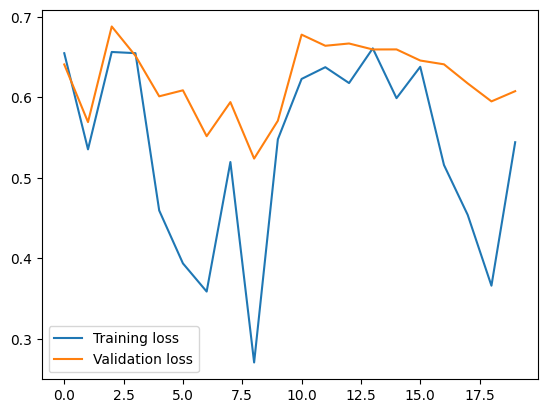

In [126]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label="Training loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()

## Do the following (5 points)
* **\[1 point\]** Add an accuracy function and report the accuracy of the training, validation, and test set.
* **\[2 points\]** Create an LSTM class which uses an LSTM instead of an RNN. Compare its results with the RNN.
  * Look at the [LSTM documentation of pyTorch](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html).
* **\[1 point\]** Implement a function which takes any text and returns the model's prediction.
    * The function should have a string as input and return a class (0 or 1) and its confidence (between 0 and 1).
* **\[Bonus\]** Create a bidirectional LSTM (BiLSTM) class to classify your sentences. Report the accuracy on the training and test data.
    * **Beware of the behaviour of the output layer.** For a bidirectional LSTM, the output layer concatenates the forward and backward vector of each token. But we need to use the forward output of the last token, and the backward output of the first token, as input to our output layer.
* **\[1 point\]** With your best classifier, look at two wrongly classified examples on the test set. Try explaining why the model was wrong.
* **\[Bonus\]** Try finding better hyperparameters (dimensions, number of layers, ...). Document your experiments and results.